In [8]:
%matplotlib inline
import math
import time
import random
import numpy as np
import torch
from d2l import torch as d2l

In [9]:
n = 10000
a = torch.ones([n])
b = torch.ones(n)
print(a, b)

tensor([1., 1., 1.,  ..., 1., 1., 1.]) tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [10]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [11]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.10717 sec'

In [12]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

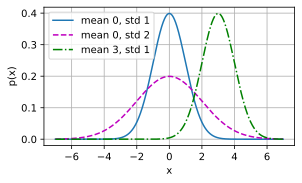

In [13]:
def normal(x, u, s):
    p = 1 / math.sqrt(2 * math.pi * s**2)
    return p * np.exp(-0.5 / s**2 * (x - u)**2)
X = torch.arange(-7, 7, 0.01)
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(X, [normal(X, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## 线性回归实现

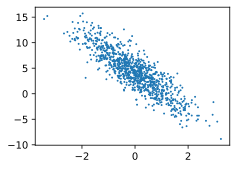

In [50]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))
w = torch.tensor([2, -3.4])
b = 4.2
features, labels = synthetic_data(w, b, 1000)
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

epoch 1, loss 0.032092
epoch 2, loss 0.000112
epoch 3, loss 0.000051
epoch 4, loss 0.000051
epoch 5, loss 0.000051
epoch 6, loss 0.000051
epoch 7, loss 0.000051
epoch 8, loss 0.000051
epoch 9, loss 0.000051
epoch 10, loss 0.000051


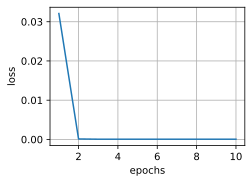

In [69]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

def sgd(params, lr, batch_size):
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

w  = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss
loss_list = []
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        loss_list.append(float(train_l.mean()))
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
d2l.plot(np.arange(1, num_epochs + 1), loss_list, 'epochs', 'loss')

In [52]:
from torch.utils import data

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [53]:
next(iter(data_iter))

[tensor([[ 0.6239,  1.1918],
         [-0.7602,  1.4860],
         [ 1.3335,  1.0350],
         [-1.9359, -0.6558],
         [-0.6147, -0.7542],
         [-0.0257, -0.6727],
         [ 1.5906, -1.3141],
         [ 0.2826,  0.4515],
         [-1.1999, -0.7723],
         [ 0.4114, -0.2924]]),
 tensor([[ 1.4092],
         [-2.3923],
         [ 3.3584],
         [ 2.5517],
         [ 5.5332],
         [ 6.4584],
         [11.8586],
         [ 3.2129],
         [ 4.4313],
         [ 6.0115]])]

In [62]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.03)

num_epochs = 10
loss_list = []
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    loss_list.append(l.item())
    print(f'epoch {epoch + 1}, loss {l:f}')

print(f'w的估计: {net[0].weight.data} b: {net[0].bias.data}')

epoch 1, loss 0.000196
epoch 2, loss 0.000102
epoch 3, loss 0.000102
epoch 4, loss 0.000103
epoch 5, loss 0.000104
epoch 6, loss 0.000103
epoch 7, loss 0.000102
epoch 8, loss 0.000103
epoch 9, loss 0.000102
epoch 10, loss 0.000102
w的估计: tensor([[ 2.0001, -3.4006]]) b: tensor([4.2007])


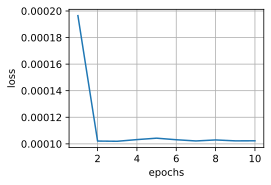

In [63]:
d2l.plot(np.arange(1, num_epochs + 1), loss_list, 'epochs', 'loss')